In [19]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import scipy.signal as signal
import os
import pickle

In [20]:
def normCrossCor(x,y):
    xcorr = signal.correlate(x, y, mode='full', method='auto')
    acor_norm = xcorr/np.sqrt(sum(abs(x)**2)*sum(abs(y)**2));
    lags = signal.correlation_lags(len(x), len(y), mode='full')
    return(lags, acor_norm)

In [21]:
filepath= './dataFolder/TrackingData_2022_11_10/thresholded_bodyparts/'
trackPoints_files = glob.glob(filepath + '*bodyparts.csv')

filepath_another = './dataFolder/TrackingData_2022_11_10/ErrorAngle/'
pilifer_signal_files = glob.glob(filepath_another + '*errorAngle.csv')

In [22]:
pilifer_signal_files[-5]

'./dataFolder/TrackingData_2022_11_10/ErrorAngle\\V_m4_130722_errorAngle.csv'

In [25]:
# fig_directory_name = './dataFolder/TrackingData_2022_11_10/ErrorAngle/Plots/CrossCorrelation/'
# output_directory = './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor/'

freq = 100
dt = 1/freq

f = pilifer_signal_files[-5]
pilifer_signal = pd.read_csv(f, index_col=0)
mothID = f.split('\\')[-1][:-15]

trackPoints = pd.read_csv([file for file in trackPoints_files if mothID in file][0], index_col=0)

pilifer_signal_smooth = signal.savgol_filter(pilifer_signal.values.flatten(), 5, 3)
pilifer_signal_smooth_deg = pilifer_signal_smooth*(180/np.pi)

body_lateral = trackPoints.loc[:,'body_x']
nectary_lateral = trackPoints.loc[:,'nectary_x']

lags = signal.correlation_lags(len(nectary_lateral), len(pilifer_signal_smooth_deg))

lags, xcorr_nect_pilifer = normCrossCor(nectary_lateral, pilifer_signal_smooth_deg)
lags_1, xcorr_pilifer_body = normCrossCor(pilifer_signal_smooth_deg, body_lateral)
lags_2, xcorr_nect_body = normCrossCor(nectary_lateral, body_lateral)

# Store in a dictionary (recommended for easier retrieval)
data_dict = {
    'timedelay': lags,
    'nectary_pilifer_xcorr': xcorr_nect_pilifer,
    'pilifer_body_xcorr': xcorr_pilifer_body,
    'nectary_body_xcorr': xcorr_nect_body
}

# # Define the filename for the pickle file
# filename = 'CrossCor_' + mothID + '.pkl'
# full_path = os.path.join(output_directory, filename)

#     # Dump the data to the pickle file
#     # Using the dictionary for demonstration
#     with open(full_path, 'wb') as pickle_f:
#         pickle.dump(data_dict, pickle_f)
    

#     plt.legend()
#     f.savefig(fig_directory_name + mothID + '_crosscor.png')

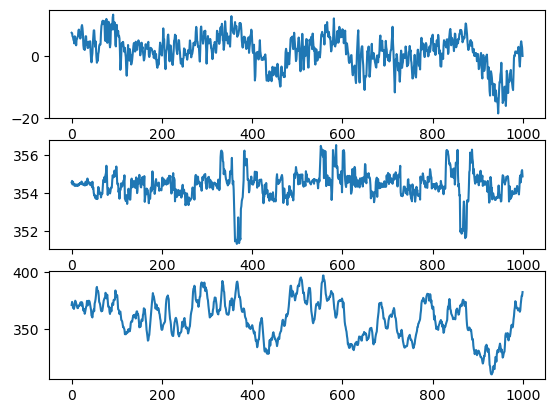

In [30]:
f, ax = plt.subplots(3,1)
ax = ax.ravel()
ax[0].plot(pilifer_signal_smooth_deg)
ax[1].plot(nectary_lateral)
ax[2].plot(body_lateral)

In [67]:
x = pilifer_signal_smooth_deg
y = nectary_lateral
z = body_lateral
lags, xcorr_self = normalized_xcorr_with_lags(y,y)
lags, xcorr = normalized_xcorr_with_lags(y,z)

# Find the lag at maximum correlation
best_lag = lags[np.argmax(xcorr)]
# acor_norm = xcorr/np.sqrt(sum(abs(x)**2)*sum(abs(y)**2));

In [62]:
def normalized_xcorr_with_lags(x, y):
    # Convert to numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Zero-mean and normalize (important!)
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)

    # Full cross-correlation
    corr = signal.correlate(x, y, mode='full')

    # Normalize by length
    corr /= len(x)

    # Compute lag array
    # Lags range from -(len(x)-1) to +(len(y)-1)
    lags = np.arange(-len(x)+1, len(y))

    return corr, lags

Text(0, 0.5, 'normalized_crossCorrelation')

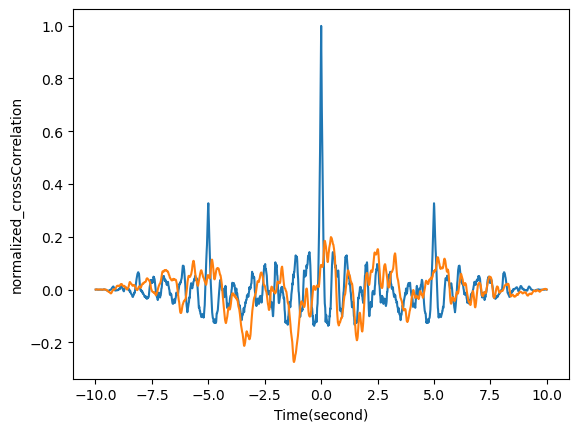

In [65]:
plt.plot(lags*dt, xcorr_self)
plt.plot(lags*dt, xcorr)
plt.xlabel('Time(second)')
plt.ylabel('normalized_crossCorrelation')

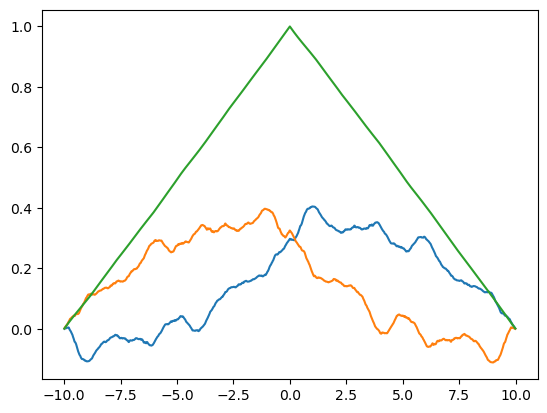

In [26]:
f = plt.figure()
plt.plot(lags*dt, xcorr_nect_pilifer, label = 'nectary-pilifer')
plt.plot(lags_1*dt, xcorr_pilifer_body, label = 'pilifer-body')
plt.plot(lags_2*dt, xcorr_nect_body, label = 'nectary-body')

## get the extreme values and put it in a form of a plot

In [ ]:
output_directory = './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor/'
files = glob.glob(output_directory + 'CrossCor*')

In [ ]:
input_output = ['nectary-pilifer', 'pilifer-body', 'nectary-body']
variables = ['maxAtZero', 'max', 'delTatMax']

cols = pd.MultiIndex.from_product(
    [input_output, variables],
    names=['input_output', 'variables']
)

# Prepare an empty list to collect each ID's data row
rows = []
ids = []

for xcorr_file in files:
    try:
        with open(xcorr_file, 'rb') as f:
            loaded_data = pickle.load(f)
        
        mothID = xcorr_file.split('\\')[-1][9:-4]
        
        ts = loaded_data['timedelay']
        xcorr_nectary_pilifer = loaded_data['nectary_pilifer_xcorr']
        xcorr_pilifer_body = loaded_data['pilifer_body_xcorr']
        xcorr_nectary_body = loaded_data['nectary_body_xcorr']
        
    except Exception as e:
        print(f"An error occurred during loading: {e}")
        
    # get the max or minimum value of coherence
    nect_pilifer_max = xcorr_nectary_pilifer[np.argmax(abs(xcorr_nectary_pilifer))]
    pilifer_body_max = xcorr_pilifer_body[np.argmax(abs(xcorr_pilifer_body))]
    nect_body_max = xcorr_nectary_body[np.argmax(abs(xcorr_nectary_body))]
    
    # get the detT at which it was max
    nect_pilifer_delTmax = ts[np.argmax(abs(xcorr_nectary_pilifer))]
    pilifer_body_delTmax = ts[np.argmax(abs(xcorr_pilifer_body))]
    nect_body_delTmax = ts[np.argmax(abs(xcorr_nectary_body))]
    
#     # get value at T0
    zero_index = np.where(ts == 0)[0][0]
    nect_pilifer_atZero = xcorr_nectary_pilifer[zero_index]
    pilifer_body_atZero = xcorr_pilifer_body[zero_index]
    nect_body_atZero = xcorr_nectary_body[zero_index]
    
    data_row = [nect_pilifer_atZero, nect_pilifer_max, nect_pilifer_delTmax,
               pilifer_body_atZero, pilifer_body_max, pilifer_body_delTmax,
               nect_body_atZero, nect_body_max, nect_body_delTmax]
    
    # Store results
    rows.append(data_row)
    ids.append(mothID)

# Build the final DataFrame
df = pd.DataFrame(rows, index=ids, columns=cols)
df.to_csv('./dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor/' + 'allmoths.csv')

In [ ]:
df